In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import vocab
from torchinfo import summary
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset, DatasetDict

from transformers import DataCollatorForTokenClassification
import random

from nltk.corpus import brown

from pathlib import Path
import os
import sys
from itertools import chain

from collections import Counter

### Define Paths

In [33]:
base_path = Path("C:/Users/shaur/Desktop/Research/low_resource_training/pos_tagging")
artifacts_path = os.path.join(base_path, "artifacts")
word2vec_model_path = os.path.join(artifacts_path, "word2vec_model/GoogleNews-vectors-negative300.bin")

### Load Data

In [34]:
brown_corpus = brown.tagged_sents(tagset='universal')
tagged_sentences = brown_corpus

In [35]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0].lower())  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [36]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 57340
Vocabulary size: 49815
Total number of tags: 12


In [37]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

sample Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 



In [38]:
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 25
Length of first output sequence : 25


### EDA

In [39]:
brown_df = Dataset.from_dict({
    'tokens': X,
    'pos_tags': Y
})

In [40]:
brown_df.set_format(type='pandas')
df = brown_df[:]
df.head()

,tokens,pos_tags
0,"[the, fulton, county, grand, jury, said, frida...","[DET, NOUN, NOUN, ADJ, NOUN, VERB, NOUN, DET, ..."
1,"[the, jury, further, said, in, term-end, prese...","[DET, NOUN, ADV, VERB, ADP, NOUN, NOUN, ADP, D..."
2,"[the, september-october, term, jury, had, been...","[DET, NOUN, NOUN, NOUN, VERB, VERB, VERB, ADP,..."
3,"[``, only, a, relative, handful, of, such, rep...","[., ADV, DET, ADJ, NOUN, ADP, ADJ, NOUN, VERB,..."
4,"[the, jury, said, it, did, find, that, many, o...","[DET, NOUN, VERB, PRON, VERB, VERB, ADP, ADJ, ..."


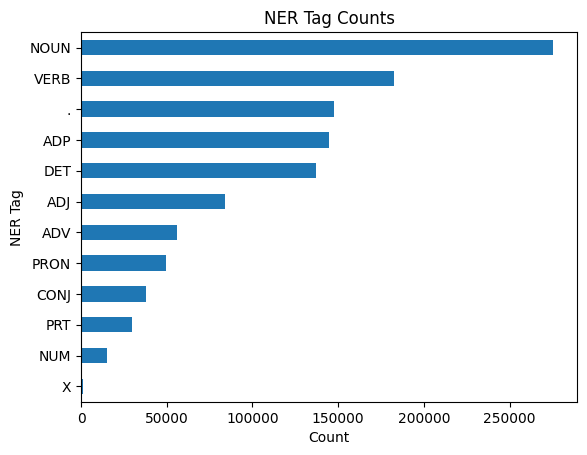

In [41]:
## Visualize distribution of class labels

all_tags = [tag for sublist in df['pos_tags'] for tag in sublist]

# Convert to a pandas Series and count occurrences of each tag
tag_counts = pd.Series(all_tags).value_counts(ascending=True)

# Plot the counts
tag_counts.plot.barh()
plt.xlabel('Count')
plt.ylabel('NER Tag')
plt.title('NER Tag Counts')
plt.show()

In [42]:
brown_df.reset_format()
brown_df = brown_df.train_test_split(test_size=0.2)
train_split_small = brown_df['train'].shuffle(seed=42).select(range(1000))
val_split_small = brown_df['test'].shuffle(seed=42).select(range(100))
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 100
    })
})

### Map targets to integers

In [43]:
class_names = list(set(chain(*brown_df['train']['pos_tags'])))
print(class_names)

['CONJ', 'DET', 'PRT', 'VERB', 'ADV', 'X', 'ADJ', 'NUM', 'PRON', 'NOUN', '.', 'ADP']


In [44]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_

label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_

In [45]:
def convert_pos_tags_to_ids(example):
    example['pos_tags'] = [label2id[tag] for tag in example['pos_tags']]
    return example

train_val_subset = train_val_subset.map(convert_pos_tags_to_ids)

Map: 100%|██████████| 100/100 [00:00<00:00, 14097.08 examples/s]


### Custom Dataset Class

In [15]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        texts = self.X[idx]
        labels = self.y[idx]
        sample = (labels, texts)
        return sample
    
train_dataset = CustomDataset(train_val_subset['train']['tokens'], train_val_subset['train']['pos_tags'])
val_dataset = CustomDataset(train_val_subset['val']['tokens'], train_val_subset['val']['pos_tags'])

In [16]:
train_dataset.__getitem__(2)

([2, 9, 3, 11, 9, 9, 10],
 ['my', 'uncle', 'looked', 'at', 'mr.', 'gorboduc', '.'])

### Create Vocab

In [17]:
def get_vocab(dataset, min_freq=1):

    counter = Counter()
    for (_, word) in dataset:
        counter.update(word)
    
    my_vocab = vocab(counter, min_freq=min_freq)
    my_vocab.insert_token('<unk>', 0)
    my_vocab.set_default_index(0)

    return my_vocab

brown_vocab = get_vocab(train_dataset, min_freq=2)
len(brown_vocab)

1718

### Collate Function for Data Loaders

In [18]:
def tokenizer(x, vocab):
    return [vocab[token] for token in x]

In [19]:
def collate_batch_emb(batch):
    """
    Collates a batch of samples into tensors of labels and texts.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing two tensors, one for labels and one for texts.
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)
    
    # Convert the list of labels into a tensor of dtype int32
    labels = torch.cat([torch.tensor(label, dtype=torch.int64) for label in labels])

    # Convert the list of texts into a tensor; each text is transformed into a list of vocabulary indices using tokenizer
    indices = torch.cat([torch.tensor(tokenizer(text_list, brown_vocab), dtype=torch.int64) for text_list in texts])

    return labels, indices

In [20]:
torch.manual_seed(0)
batch_size = 2
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_batch_emb
                )

In [21]:
# iterate over the dataloader
torch.manual_seed(0)
for label, text in train_loader:
    print(label, text)
    break

tensor([ 7,  3,  3,  7,  4,  4, 11,  6, 10,  9,  3,  3,  7,  4, 10]) tensor([ 78, 233, 185, 104,  58, 612,  58, 539, 184, 421,   0, 192,   2, 829,
          4])



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\shaur\anaconda3\envs\research_env\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\shaur\anaconda3\envs\research_env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\shaur\anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\shaur\anaconda3\envs\research_env\lib\site-packages\traitlets\config\application.py", line 1075, in launc

### Simple MLP

In [22]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        # EmbeddingBag_layer->Linear->ReLU->BatchNorm->Dropout->Linear->ReLU->BatchNorm->Dropout->Linear

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # First Linear layer
        self.linear1 = nn.Linear(embedding_dim, hidden_dim1)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=drop_prob1)

        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=drop_prob2)

        # Final Linear layer
        self.linear3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, indices):

        # Pass data through the embedding layer
        x = self.embedding(indices)

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)

        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)

        # Final linear layer
        x = self.linear3(x)

        return x


In [23]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = SimpleMLP(vocab_size=len(brown_vocab) , embedding_dim=200, hidden_dim1=100, hidden_dim2=20, drop_prob1=0.5, drop_prob2=0.5, num_outputs=len(label2id))

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=data, device=device, depth =10, verbose = False)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [5, 12]                   --
├─Embedding: 1-1                         [5, 200]                  343,600
├─Linear: 1-2                            [5, 100]                  20,100
├─BatchNorm1d: 1-3                       [5, 100]                  200
├─Dropout: 1-4                           [5, 100]                  --
├─Linear: 1-5                            [5, 20]                   2,020
├─BatchNorm1d: 1-6                       [5, 20]                   40
├─Dropout: 1-7                           [5, 20]                   --
├─Linear: 1-8                            [5, 12]                   252
Total params: 366,212
Trainable params: 366,212
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.46
Estimated Total Size (MB): 1.48

## Functions to Train and Evaluate Models

### Step Function

In [24]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = torch.argmax(outputs.data, 1)
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return None, outputs, correct


In [25]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        running_train_correct += correct

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_acc


In [26]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, correct = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            running_val_correct += correct

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_acc


In [27]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc*100:.2f}%")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


## Train Model

In [28]:
# model Parameters
EMBED_DIM=512
VOCAB_SIZE=len(brown_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=len(label2id)

# training
EPOCHS=5
BATCH_SIZE=4
LEARNING_RATE=0.001
WEIGHT_DECAY=0.1

In [29]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = collate_batch_emb

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.CrossEntropyLoss()

# Define the model with specified hyperparameters
model_brown = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_brown.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [31]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model_imdb = model_brown.to(device)
    model_imdb.eval()
    # Forward pass
    print("Im here")
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_imdb(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


Im here


TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not tuple